In [ ]:
!pip install tensorflow

Data Summary:
               Age  Department         Salary  YearsAtCompany  \
count  100.000000  100.000000     100.000000      100.000000   
mean    39.650000    2.140000   79398.590000        6.340000   
std      9.532904    1.428569   22377.844407        4.499652   
min     22.000000    0.000000   41928.000000        0.000000   
25%     33.000000    1.000000   59657.000000        3.000000   
50%     39.500000    2.000000   79312.500000        6.000000   
75%     48.000000    3.250000   98635.750000       10.000000   
max     54.000000    4.000000  119864.000000       14.000000   

       PerformanceScore  AttritionFlag  
count        100.000000     100.000000  
mean          76.070000       0.240000  
std           15.541573       0.429235  
min           50.000000       0.000000  
25%           62.500000       0.000000  
50%           77.000000       0.000000  
75%           90.000000       0.000000  
max           99.000000       1.000000  


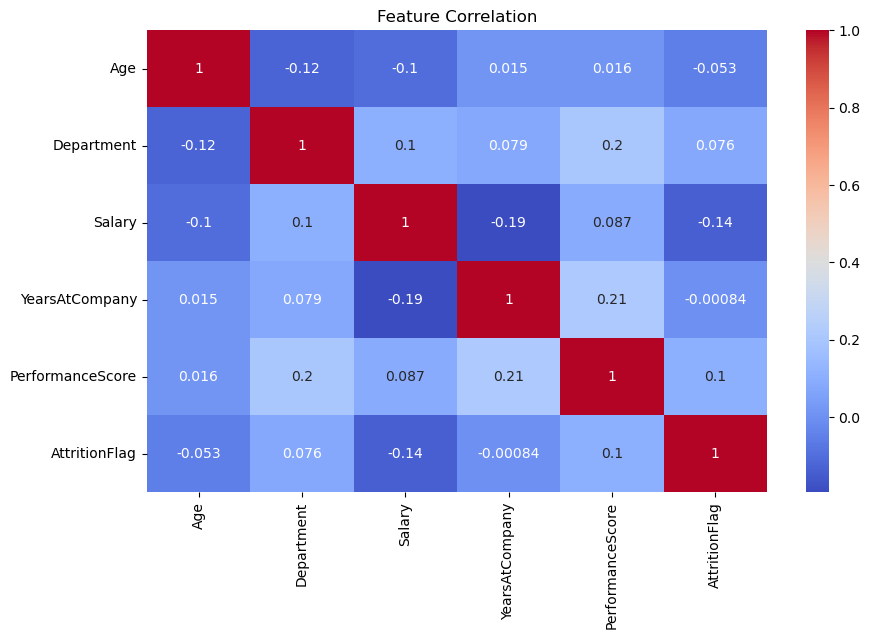

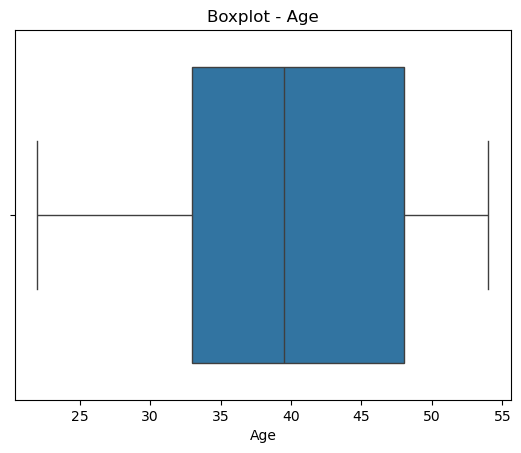

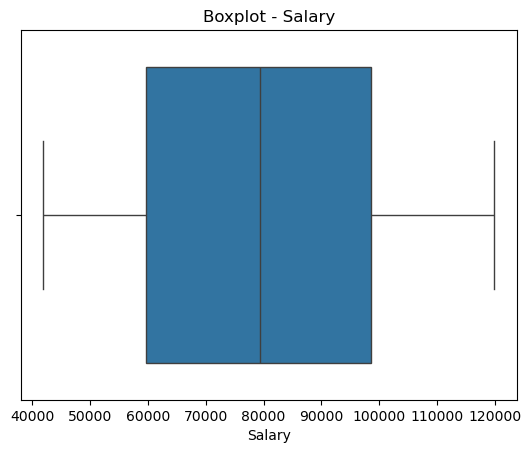

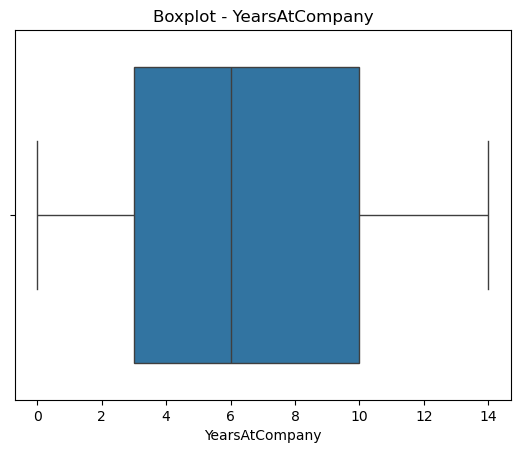

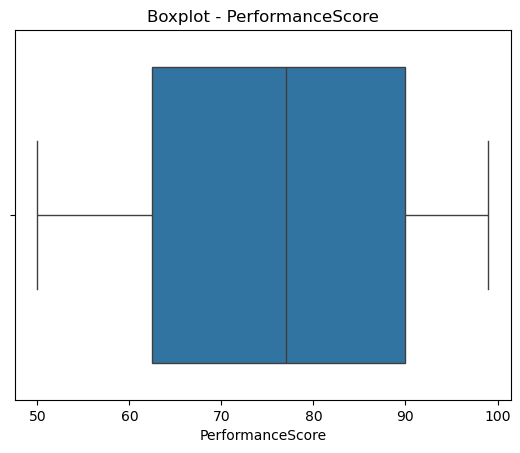

Attrition Probability by Score:
 ScoreGroup
<60       0.166667
60-70     0.166667
70-80     0.318182
80-90     0.263158
90-100    0.260870
Name: AttritionFlag, dtype: float64
Estimated P(Attrition | Low Performance): 0.167
ANOVA - F-stat: 3.892409137621655 P-value: 0.005688725422530428
Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        15
           1       0.00      0.00      0.00         5

    accuracy                           0.75        20
   macro avg       0.38      0.50      0.43        20
weighted avg       0.56      0.75      0.64        20



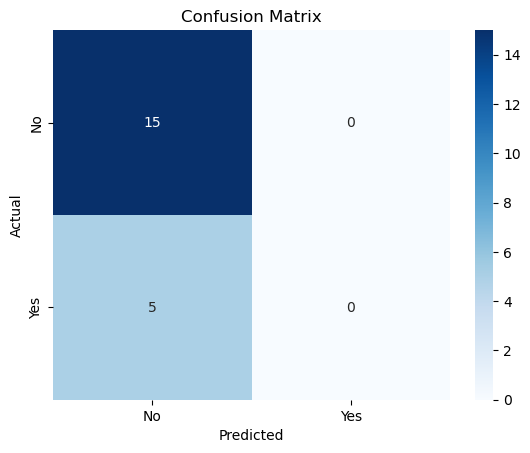

Random Forest Results:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        15
           1       1.00      0.40      0.57         5

    accuracy                           0.85        20
   macro avg       0.92      0.70      0.74        20
weighted avg       0.88      0.85      0.82        20



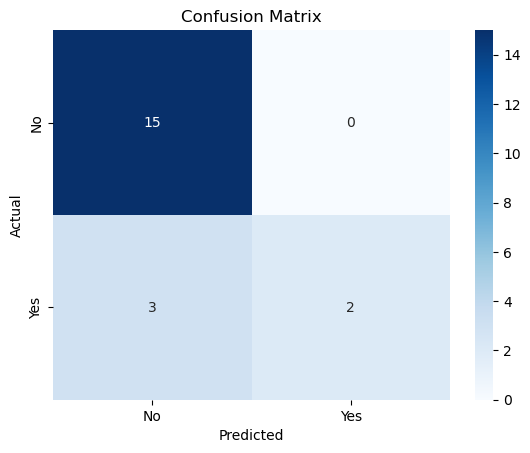

Linear Regression Metrics:
R2 Score: 1.0
MSE: 1.2369338993865466e-28


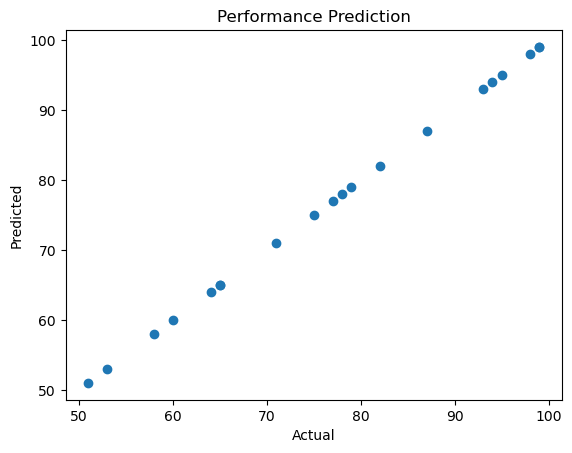

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
DL Regression R2: -15.465568542480469
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
DL Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        15
           1       0.00      0.00      0.00         5

    accuracy                           0.75        20
   macro avg       0.38      0.50      0.43        20
weighted avg       0.56      0.75      0.64        20



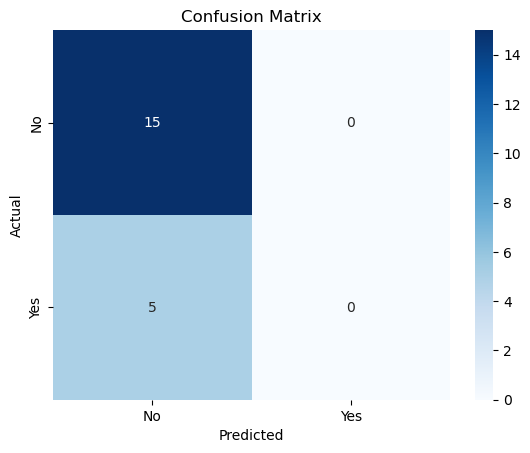


Top Influential Features (Random Forest):
PerformanceScore    0.270637
Salary              0.252645
Age                 0.220331
YearsAtCompany      0.162896
Department          0.093491
dtype: float64

Attrition Rate by Department:
Department
Finance      0.187500
HR           0.136364
IT           0.315789
Marketing    0.388889
Sales        0.200000
Name: AttritionFlag, dtype: float64

Suggested Recommendations:
- Monitor high-risk departments with above-average attrition.
- Provide training support for employees with declining performance.
- Consider reward-based incentives aligned with performance scores.


In [10]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error
from scipy.stats import f_oneway

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Plot Confusion Matrix

def plot_matrix(cm, labels, title="Confusion Matrix"):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Step 1: Load and Preprocess Data

file_path = "Employee_data.csv"

if not os.path.exists(file_path):
    data = {
        "EmployeeID": [f"E{str(i).zfill(3)}" for i in range(1, 101)],
        "Name": np.random.choice(["Amit", "Sneha", "Rahul", "Neha", "Raj", "Pooja", "Vivek"], 100),
        "Age": np.random.randint(22, 50, 100),
        "Department": np.random.choice(["HR", "Sales", "IT", "Finance"], 100),
        "Salary": np.random.randint(35000, 120000, 100),
        "YearsAtCompany": np.random.randint(0, 15, 100),
        "PerformanceScore": np.random.randint(50, 100, 100),
        "Attrition": np.random.choice(["Yes", "No"], 100, p=[0.2, 0.8])
    }
    pd.DataFrame(data).to_csv(file_path, index=False)

df = pd.read_csv(file_path)
df.drop_duplicates(inplace=True)

for col in df.columns:
    if df[col].dtype == "object":
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

# Encode target

df["AttritionFlag"] = df["Attrition"].map({"Yes": 1, "No": 0})

# Clean columns
clean_df = df.drop(columns=["Name", "Attrition"])
label_encoder = LabelEncoder()
clean_df["Department"] = label_encoder.fit_transform(clean_df["Department"])

# Step 2: EDA

print("Data Summary:\n", clean_df.describe())

plt.figure(figsize=(10, 6))
sns.heatmap(clean_df.select_dtypes(include='number').corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

# Outlier Check
for col in ["Age", "Salary", "YearsAtCompany", "PerformanceScore"]:
    sns.boxplot(x=clean_df[col])
    plt.title(f"Boxplot - {col}")
    plt.show()

# Step 3: Statistics

clean_df["ScoreGroup"] = pd.cut(clean_df["PerformanceScore"], bins=[0, 60, 70, 80, 90, 100],
                                 labels=["<60", "60-70", "70-80", "80-90", "90-100"])
probability_table = clean_df.groupby("ScoreGroup")["AttritionFlag"].mean()
print("Attrition Probability by Score:\n", probability_table)

# Bayes theorem estimate
low_perf = clean_df[clean_df["PerformanceScore"] < 70]
P_low = len(low_perf) / len(clean_df)
P_attr = clean_df["AttritionFlag"].mean()
P_low_given_attr = len(clean_df[(clean_df["PerformanceScore"] < 70) & (clean_df["AttritionFlag"] == 1)]) / clean_df["AttritionFlag"].sum()
P_attr_given_low = (P_low_given_attr * P_attr) / P_low
print("Estimated P(Attrition | Low Performance):", round(P_attr_given_low, 3))

# ANOVA
grouped_data = [group["PerformanceScore"] for _, group in clean_df.groupby("Department")]
F_stat, p_val = f_oneway(*grouped_data)
print("ANOVA - F-stat:", F_stat, "P-value:", p_val)

# Step 4: Split and Scale

X = clean_df.drop(columns=["AttritionFlag", "ScoreGroup", "EmployeeID"])
y_class = clean_df["AttritionFlag"]
y_reg = clean_df["PerformanceScore"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class, test_size=0.2, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_c = scaler.fit_transform(X_train_c)
X_test_c = scaler.transform(X_test_c)
X_train_r = scaler.fit_transform(X_train_r)
X_test_r = scaler.transform(X_test_r)

# Step 5: ML Models

# Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train_c, y_train_c)
log_preds = log_model.predict(X_test_c)
print("Logistic Regression Results:")
print(classification_report(y_test_c, log_preds))
plot_matrix(confusion_matrix(y_test_c, log_preds), ["No", "Yes"])

# Random Forest
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train_c, y_train_c)
forest_preds = forest.predict(X_test_c)
print("Random Forest Results:")
print(classification_report(y_test_c, forest_preds))
plot_matrix(confusion_matrix(y_test_c, forest_preds), ["No", "Yes"])

# Linear Regression
regressor = LinearRegression()
regressor.fit(X_train_r, y_train_r)
reg_preds = regressor.predict(X_test_r)
print("Linear Regression Metrics:")
print("R2 Score:", r2_score(y_test_r, reg_preds))
print("MSE:", mean_squared_error(y_test_r, reg_preds))
plt.scatter(y_test_r, reg_preds)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Performance Prediction")
plt.show()

# Step 6: Deep Learning Models

# Regression
dl_reg = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_r.shape[1],)),
    Dense(32, activation="relu"),
    Dense(1)
])
dl_reg.compile(optimizer="adam", loss="mse")
dl_reg.fit(X_train_r, y_train_r, epochs=50, validation_split=0.2, verbose=0)
dl_reg_preds = dl_reg.predict(X_test_r).flatten()
print("DL Regression R2:", r2_score(y_test_r, dl_reg_preds))

# Classification
dl_class = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_c.shape[1],)),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])
dl_class.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
dl_class.fit(X_train_c, y_train_c, epochs=50, validation_split=0.2, verbose=0)
dlc_preds = (dl_class.predict(X_test_c) > 0.5).astype(int)
print("DL Classification Report:")
print(classification_report(y_test_c, dlc_preds))
plot_matrix(confusion_matrix(y_test_c, dlc_preds), ["No", "Yes"])

# Step 7: Key Findings

print("\nTop Influential Features (Random Forest):")
importance = pd.Series(forest.feature_importances_, index=X.columns)
print(importance.sort_values(ascending=False).head())

print("\nAttrition Rate by Department:")
dep_labels = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
attr_by_dept = clean_df.groupby("Department")["AttritionFlag"].mean().rename(index=dep_labels)
print(attr_by_dept)

print("\nSuggested Recommendations:")
print("- Monitor high-risk departments with above-average attrition.")
print("- Provide training support for employees with declining performance.")
print("- Consider reward-based incentives aligned with performance scores.")
